I tried to scrape revenue and budget data from Wikidata using their free API. However it turns out that wiki does not have enough non-null values of revenue and budget compared to the TMDB dataset

In [ ]:
!conda install -c conda-forge sparqlwrapper

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import csv
import time

def get_movies_query(offset):
    return '''
SELECT DISTINCT ?imdb ?title ?budget ?boxOffice
WHERE {{
    ?movie wdt:P31 wd:Q11424;
           wdt:P345 ?imdb.
    OPTIONAL {{ ?movie wdt:P2130 ?budget. }}
    OPTIONAL {{ ?movie wdt:P2142 ?boxOffice. }}
}}
LIMIT 1000
OFFSET {offset}
'''.format(offset=offset)

def fetch_data(offset=0):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(get_movies_query(offset))
    sparql.setReturnFormat(JSON)
    try:
        return sparql.query().convert()
    except Exception as e:
        print(f"Error at offset {offset}: {e}")
        return None

def save_batch(results, filename):
    with open(filename, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        for result in results["results"]["bindings"]:
            writer.writerow([
                result.get("imdb", {}).get("value", ""),
                result.get("title", {}).get("value", ""),
                result.get("budget", {}).get("value", ""),
                result.get("boxOffice", {}).get("value", "")
            ])



filename = 'wikidata_movies.csv'

# Create file with headers
with open(filename, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['IMDB_ID', 'Title', 'Budget', 'Box_Office'])

offset = 0
while True:
    print(f"Fetching records at offset: {offset}")
    results = fetch_data(offset)
    
    if not results or len(results["results"]["bindings"]) == 0:
        break
        
    save_batch(results, filename)
    offset += 1000
    time.sleep(0.5)  # Rate limiting

In [14]:
import pandas as pd
x = pd.read_csv('wikidata_movies.csv')

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251816 entries, 0 to 251815
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IMDB_ID     251816 non-null  object 
 1   Title       0 non-null       float64
 2   Budget      6868 non-null    float64
 3   Box_Office  6533 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.7+ MB


In [18]:
x.shape

(251816, 4)

In [20]:
x[x.Budget.notnull()].shape

(6868, 4)

In [21]:
x[x.Box_Office.notnull()].shape

(6533, 4)

In [23]:
x[(x.Box_Office.notnull())&(x.Budget.notnull())].shape

(4232, 4)

In [22]:
x[x.Budget>0].shape

(6868, 4)

In [24]:
x[(x.Box_Office.notnull())|(x.Budget.notnull())].describe()

,Title,Budget,Box_Office
count,0.0,6.868000e+03,6.533000e+03
mean,NaN,6.698640e+07,1.530795e+12
std,NaN,5.942218e+08,1.237211e+14
min,NaN,1.000000e+02,7.667000e+00
25%,NaN,1.207252e+06,1.960000e+06
50%,NaN,8.000000e+06,1.750000e+07
75%,NaN,4.000000e+07,1.011341e+08
max,NaN,2.400000e+10,1.000000e+16


<Axes: >

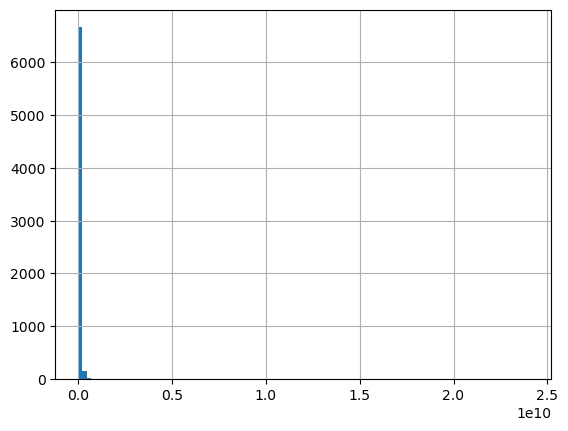

In [26]:
x[x.Budget>0].Budget.hist(bins=100)

<Axes: >

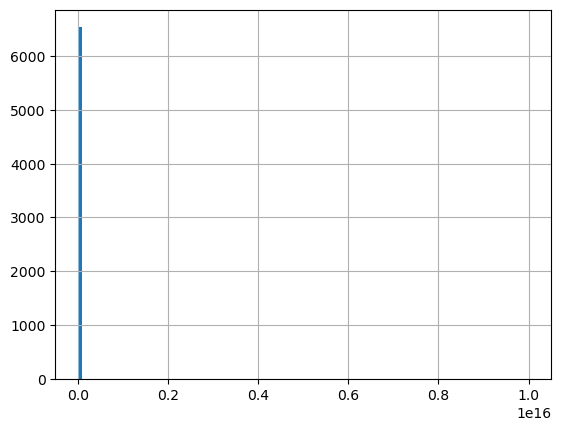

In [27]:
x[x.Box_Office>0].Box_Office.hist(bins=100)